In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import spacy
import re
import nltk
from tqdm.notebook import tqdm


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nlp = spacy.load("es_core_news_lg")

In [4]:
df = pd.read_parquet("Database/01_bbdd_think_tanks.parquet")
df["FechaPublicacion"] = pd.to_datetime(df["FechaPublicacion"], errors="coerce")
df = df[df["FechaPublicacion"].notnull()]
df = df[(df["FechaPublicacion"] >= "2019-01-01") & (df["FechaPublicacion"] <= "2023-12-31")]
df = df[df["TextoLimpio"].notnull()]

In [5]:
print(f"Total documentos en rango 2019-2023: {len(df)}")

Total documentos en rango 2019-2023: 17432


In [16]:
keywords = ["aborto", "embarazo"]

In [17]:
def contiene_keywords(text):
    return any(re.search(rf"\b{kw}\b", text.lower()) for kw in keywords)

df_focus = df[df["TextoLimpio"].apply(contiene_keywords)]
print(f"Documentos relacionados con derechos reproductivos: {len(df_focus)}")

Documentos relacionados con derechos reproductivos: 265


In [18]:
def lematizar(text):
    doc = nlp(text)
    return " ".join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and len(token) > 2])

print("Lematizando textos...")
df_focus["TextoLema"] = df_focus["TextoLimpio"].apply(lematizar)

Lematizando textos...


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11548\765063662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["TextoLema"] = df_focus["TextoLimpio"].apply(lematizar)


In [19]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words=None)
X = vectorizer.fit_transform(df_focus["TextoLema"])

In [20]:
lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=6, random_state=42)


🔹 Tópico 1:
merecer, ola, admisibilidad, exposicion, incluido, satisfaccion, etico, viernes, adulto, mentira


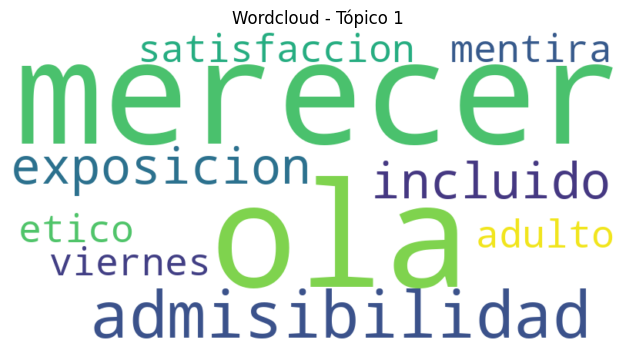


🔹 Tópico 2:
investigacion, universidad, facultad, paciente, odontologia, milei, enfermedad, embarazo, boletin, biomarcador


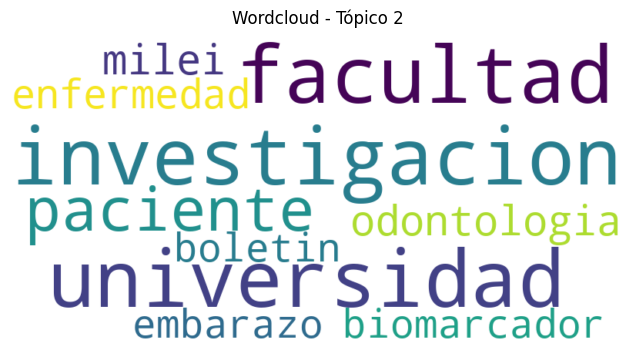


🔹 Tópico 3:
embarazo, embarazado, obstetricia, matrona, mujer, medico, autonomia, madre, sujeto, obstetrico


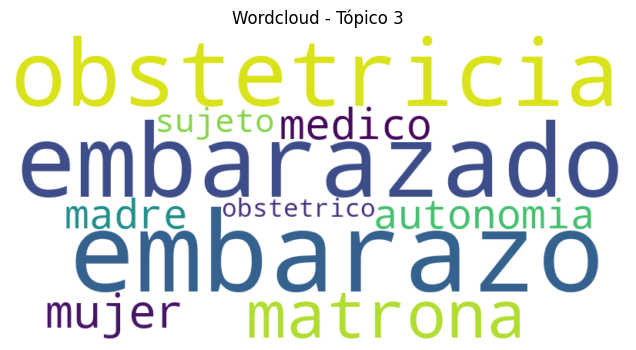


🔹 Tópico 4:
merecer, ola, admisibilidad, exposicion, incluido, satisfaccion, etico, viernes, adulto, mentira


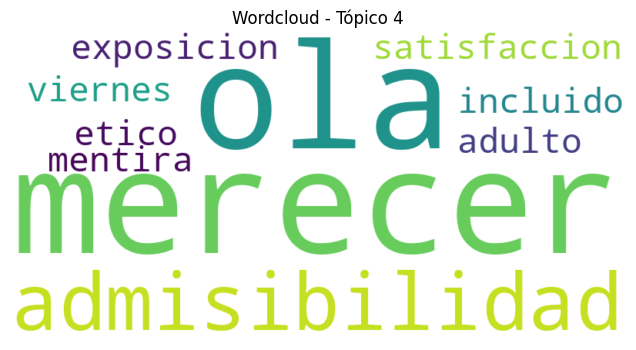


🔹 Tópico 5:
merecer, ola, admisibilidad, exposicion, incluido, satisfaccion, etico, viernes, adulto, mentira


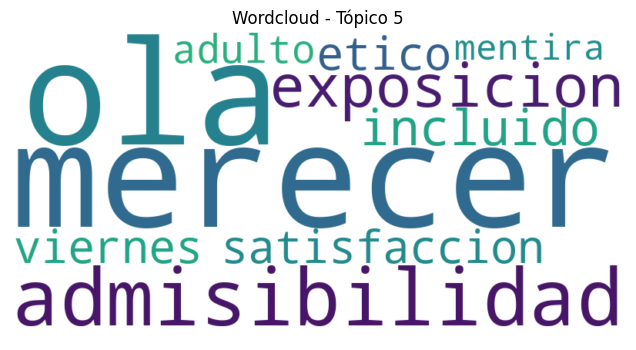


🔹 Tópico 6:
politico, derecho, social, constitucional, él, constitucion, mujer, proyecto, texto, vida


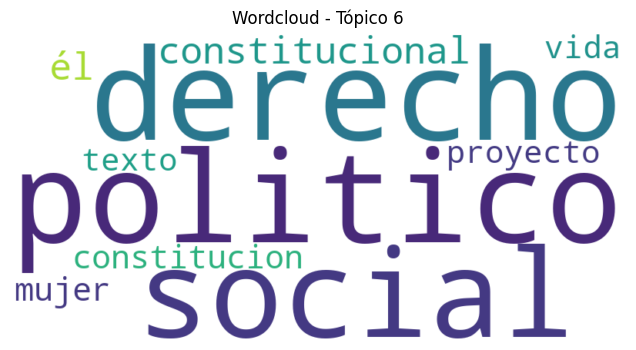

In [21]:
def mostrar_top_palabras(modelo, vectorizer, n_palabras=10):
    for idx, topic in enumerate(modelo.components_):
        print(f"\n🔹 Tópico {idx+1}:")
        palabras = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_palabras - 1:-1]]
        print(", ".join(palabras))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(palabras))
        plt.figure(figsize=(10, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Wordcloud - Tópico {idx+1}")
        plt.show()

mostrar_top_palabras(lda, vectorizer)

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11548\2863696870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["Topico"] = lda.transform(X).argmax(axis=1)
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11548\2863696870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["MesAño"] = df_focus["FechaPublicacion"].dt.to_period("M")


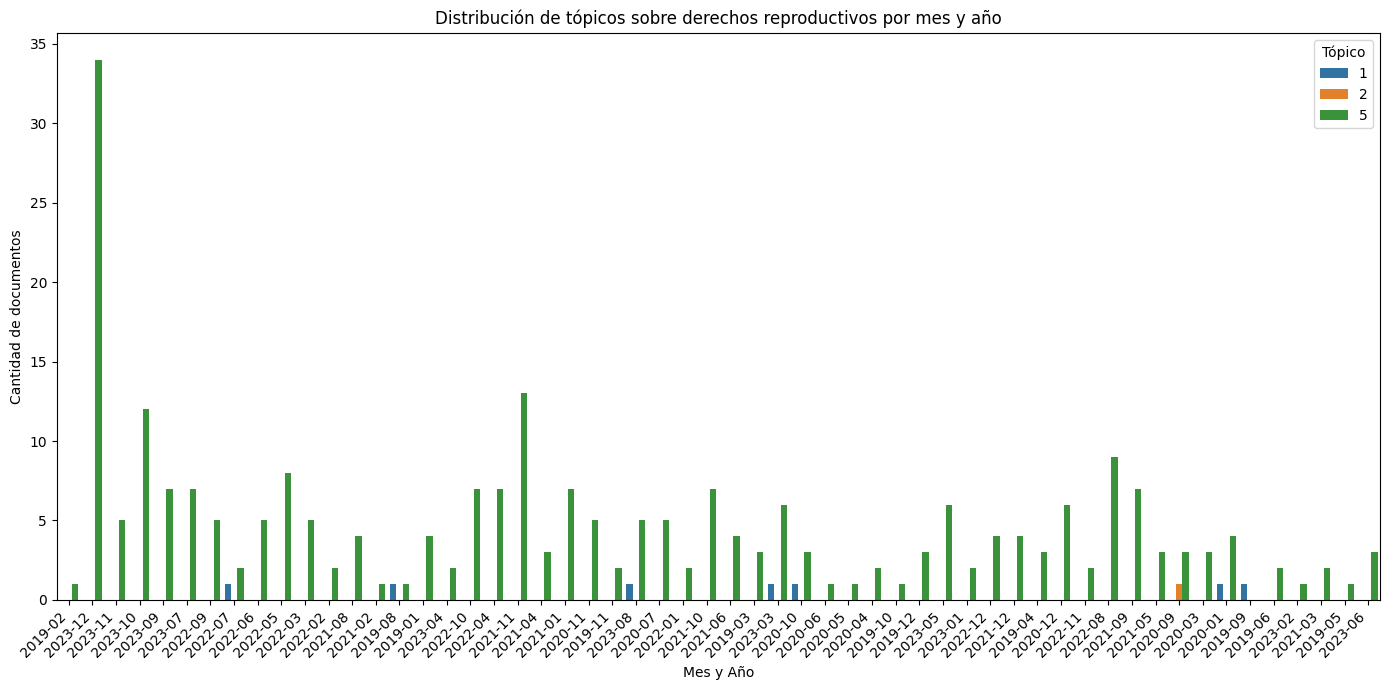

In [23]:
# Assign the most probable topic to each document
df_focus["Topico"] = lda.transform(X).argmax(axis=1)

# Extract the month and year for plotting
df_focus["MesAño"] = df_focus["FechaPublicacion"].dt.to_period("M")

# Plot the distribution of topics by month and year
plt.figure(figsize=(14, 7))
sns.countplot(data=df_focus, x="MesAño", hue="Topico", palette="tab10")
plt.title("Distribución de tópicos sobre derechos reproductivos por mes y año")
plt.xlabel("Mes y Año")
plt.ylabel("Cantidad de documentos")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tópico")
plt.tight_layout()
plt.show()


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11548\1795120914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["Think Tank"] = df_focus["Think Tank"].fillna("Sin dato")


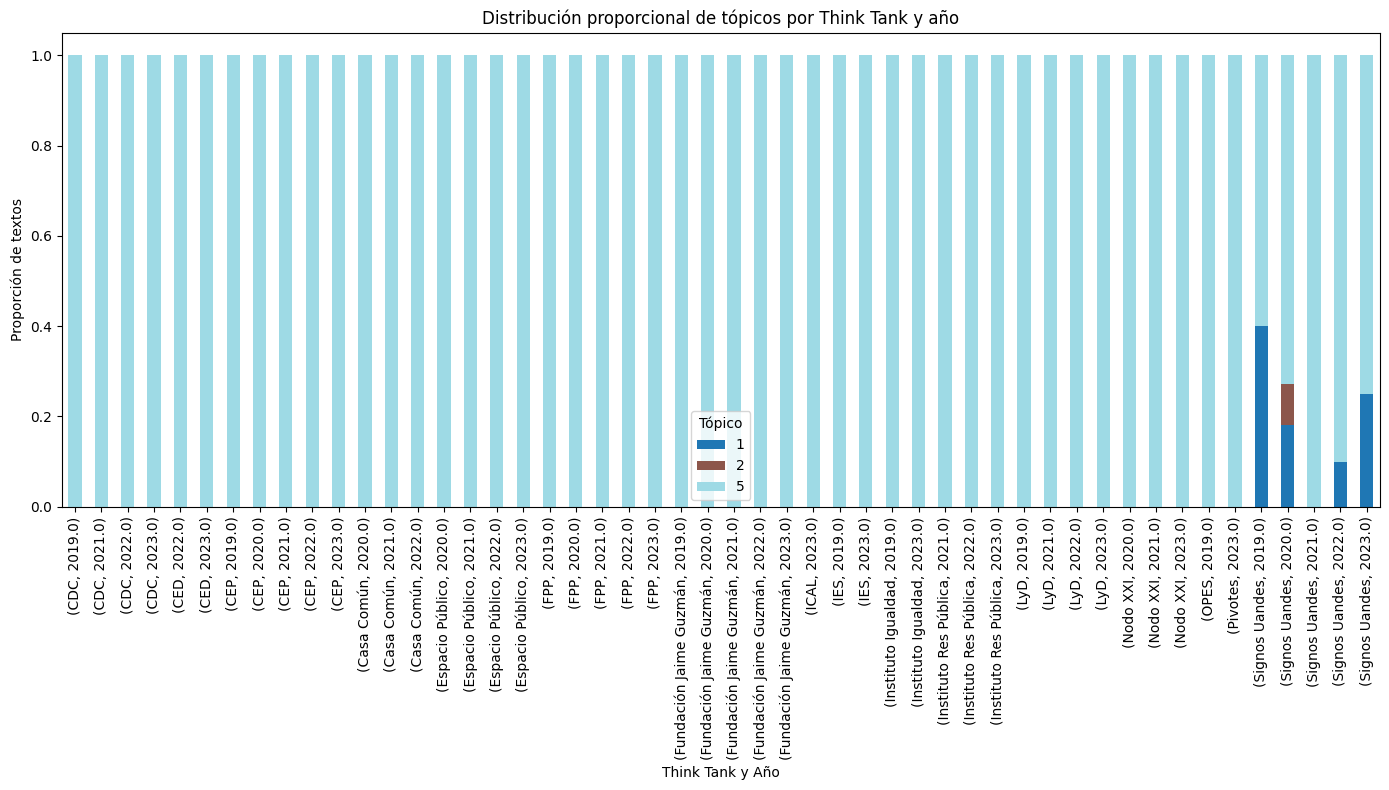

In [24]:
df_focus["Think Tank"] = df_focus["Think Tank"].fillna("Sin dato")
pivot_tt = pd.crosstab(index=[df_focus["Think Tank"], df_focus["año"]], columns=df_focus["Topico"])
pivot_tt = pivot_tt.div(pivot_tt.sum(axis=1), axis=0).fillna(0)
pivot_tt.plot(kind="bar", stacked=True, figsize=(14,8), colormap="tab20")
plt.title("Distribución proporcional de tópicos por Think Tank y año")
plt.ylabel("Proporción de textos")
plt.xlabel("Think Tank y Año")
plt.xticks(rotation=90)
plt.legend(title="Tópico")
plt.tight_layout()
plt.show()

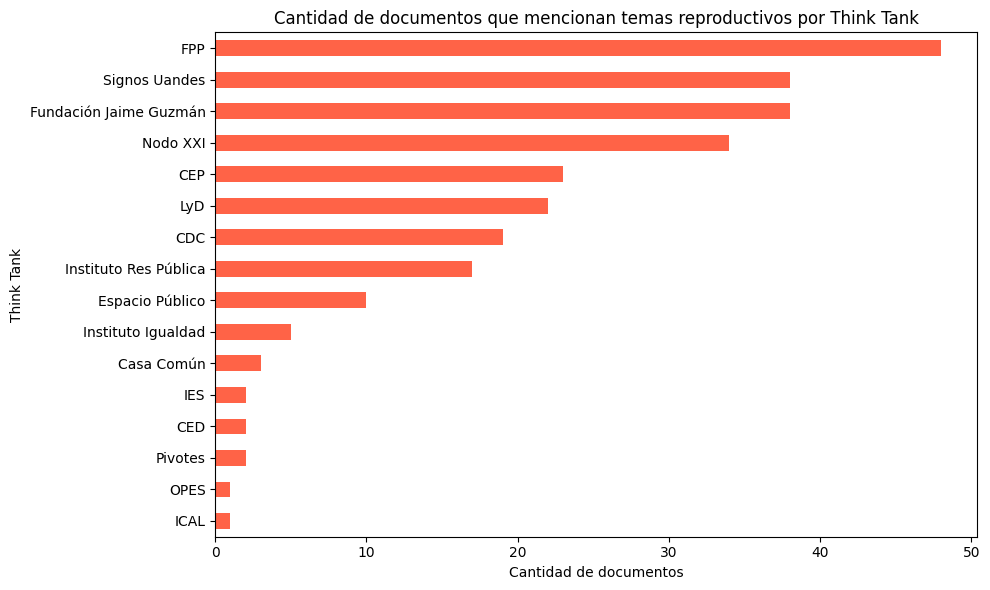

In [25]:
conteo_keywords = df_focus["Think Tank"].value_counts().sort_values(ascending=False)
conteo_keywords.plot(kind="barh", figsize=(10,6), color="tomato")
plt.title("Cantidad de documentos que mencionan temas reproductivos por Think Tank")
plt.xlabel("Cantidad de documentos")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_11548\3751176728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["fecha_str"] = df_focus["FechaPublicacion"].dt.strftime("%Y-%m")


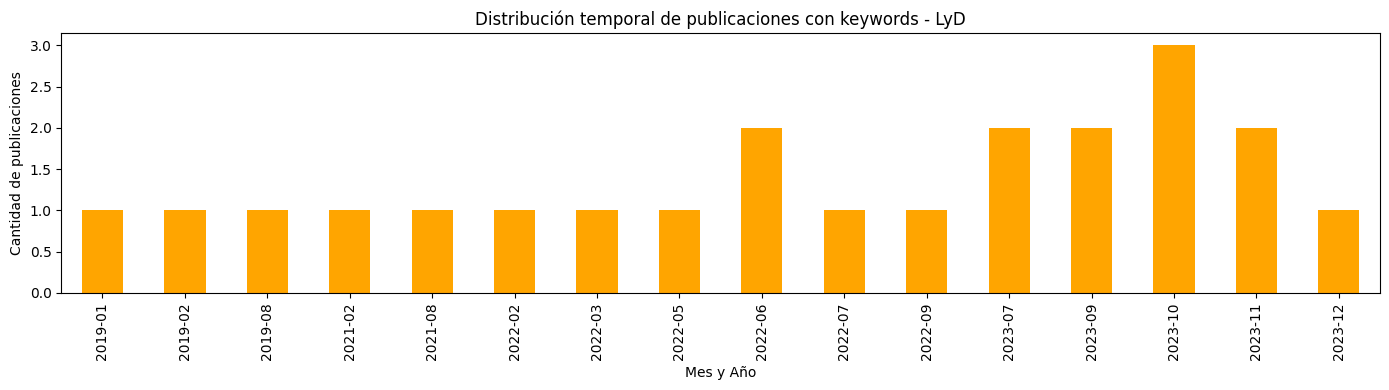

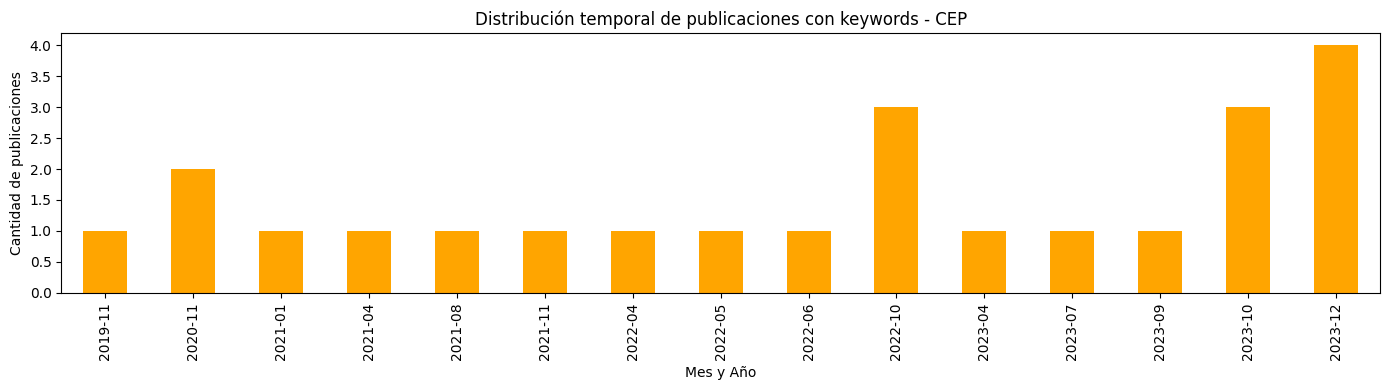

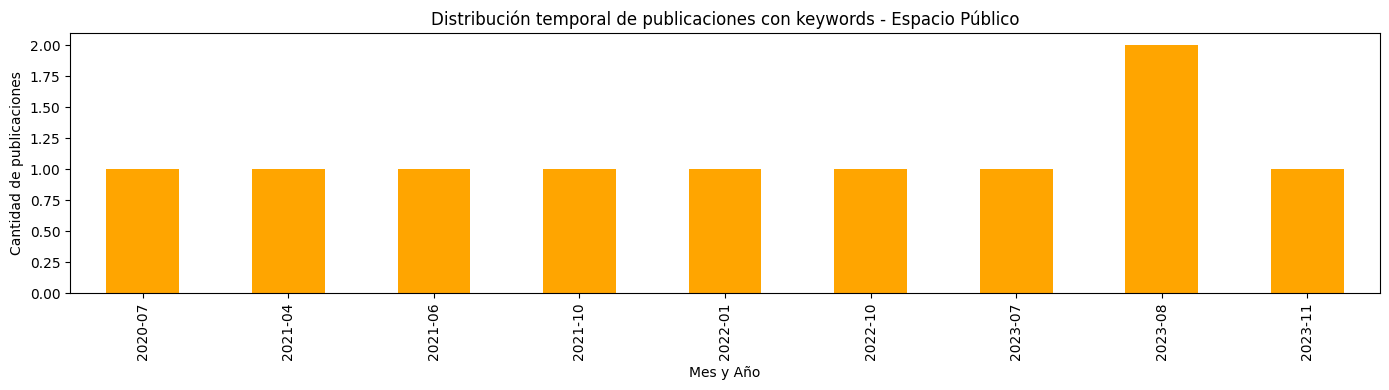

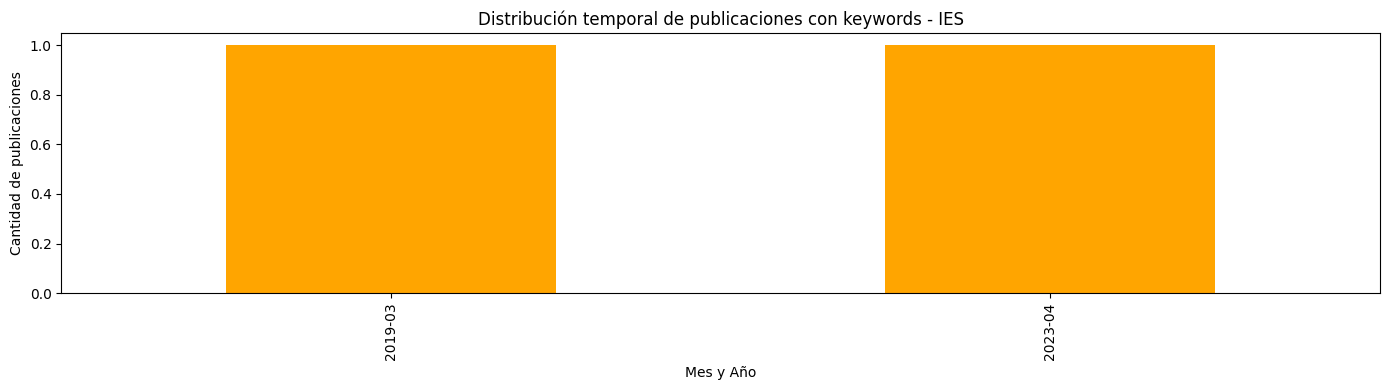

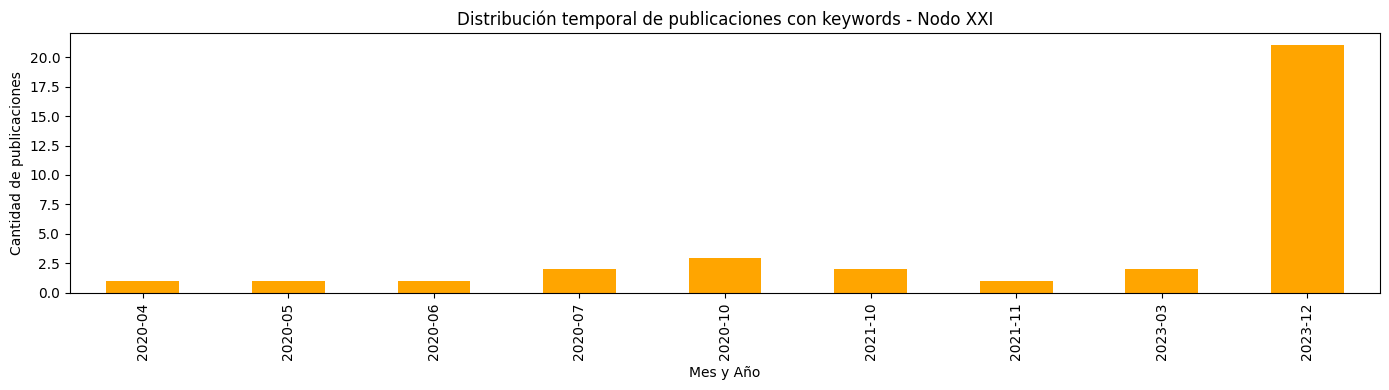

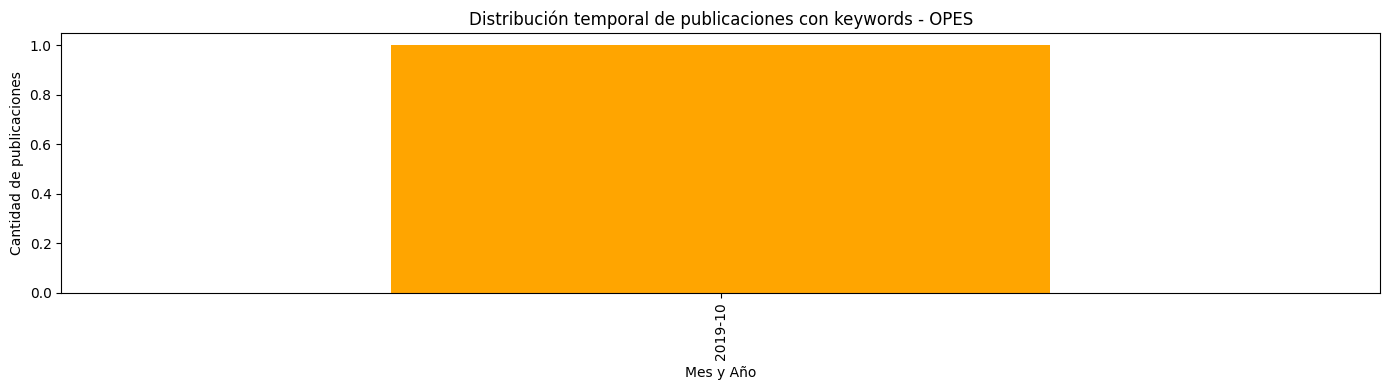

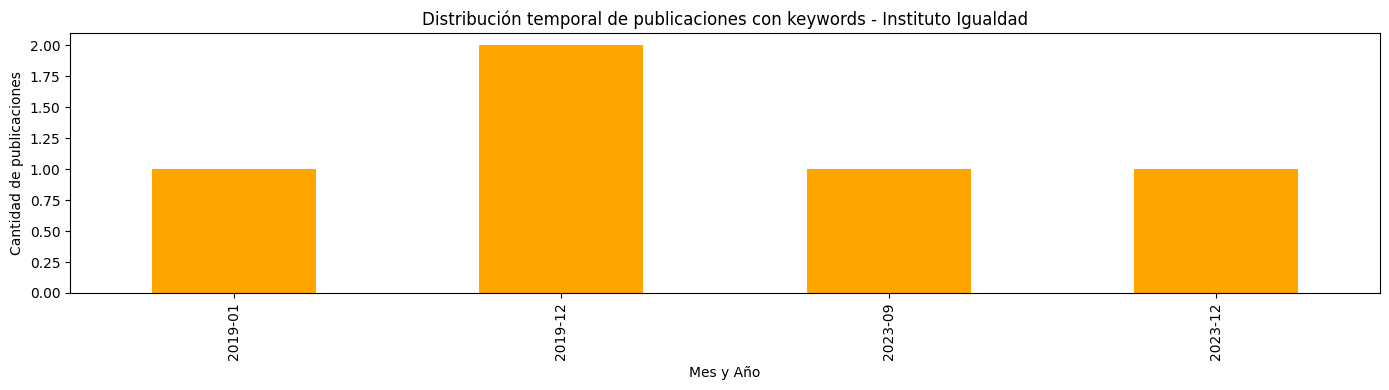

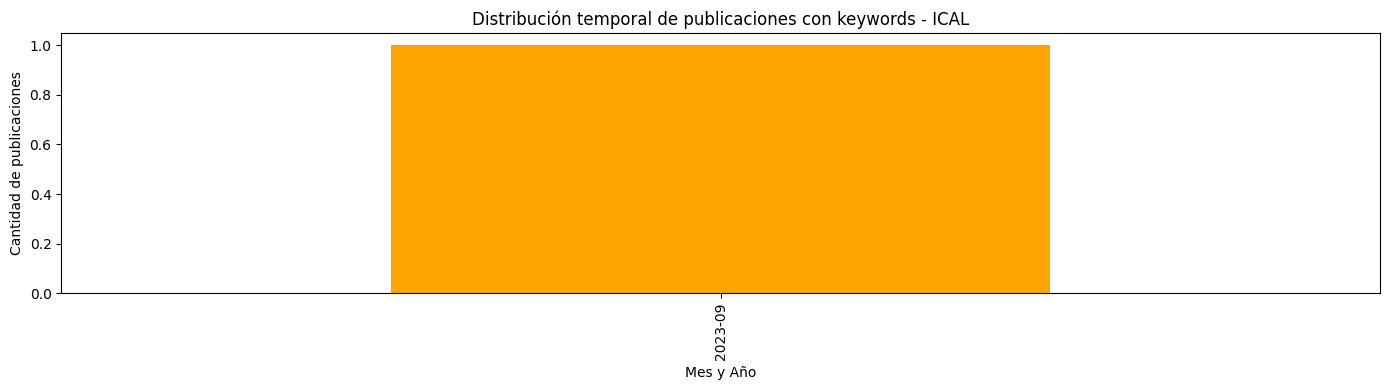

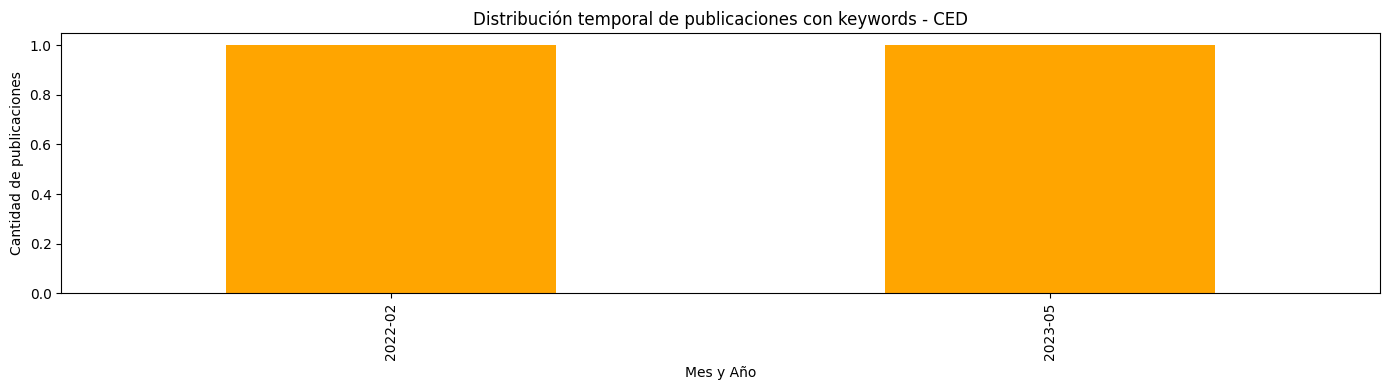

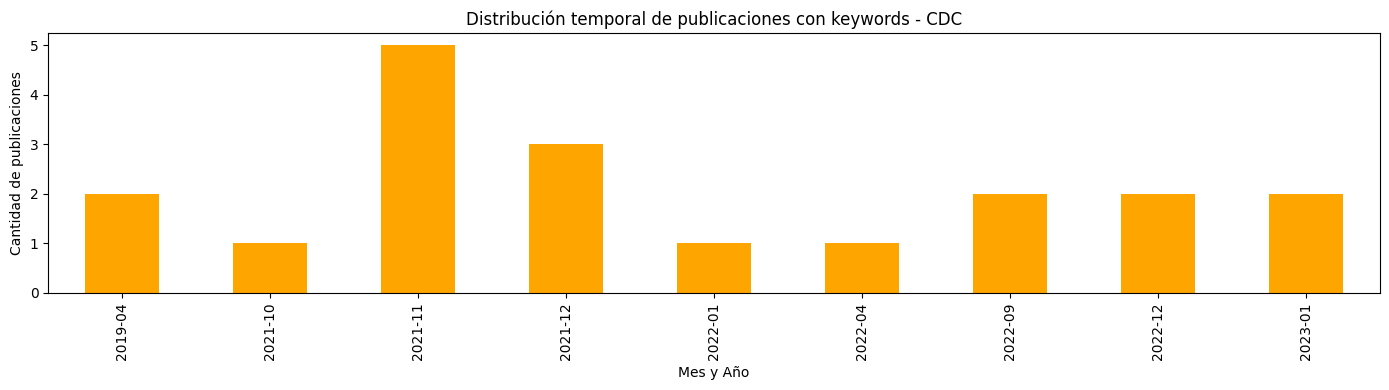

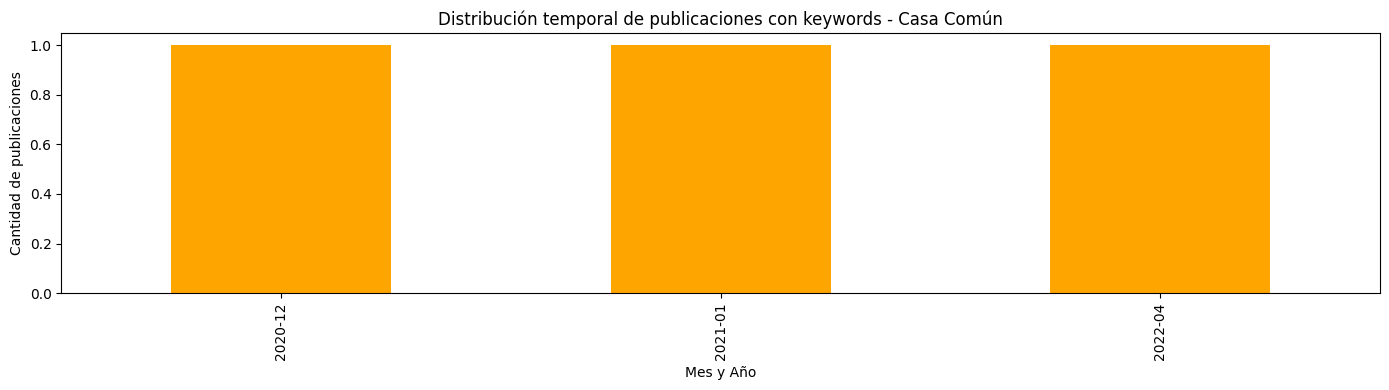

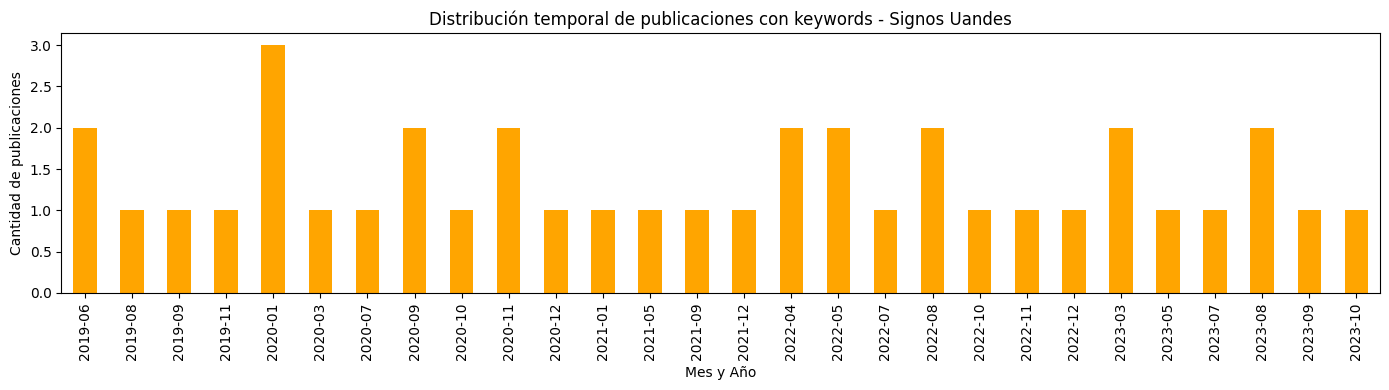

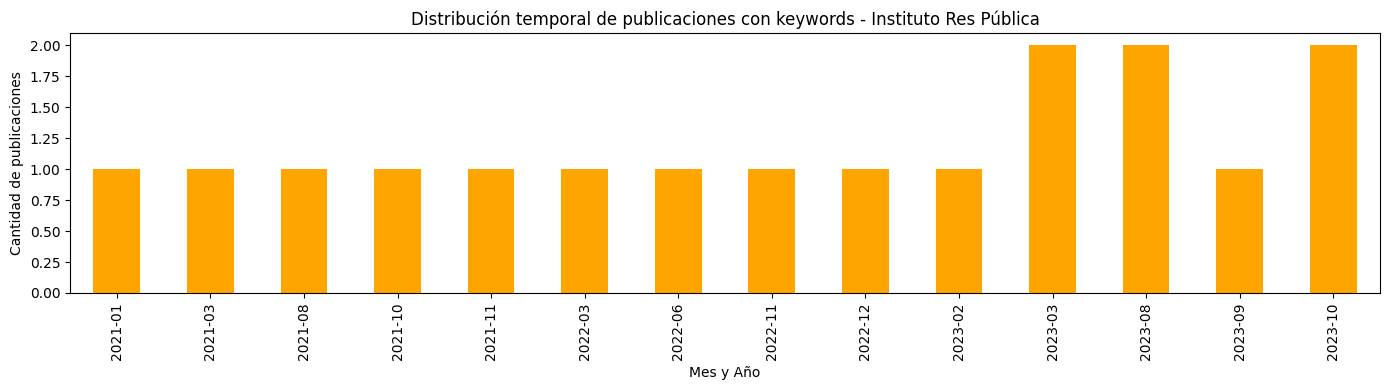

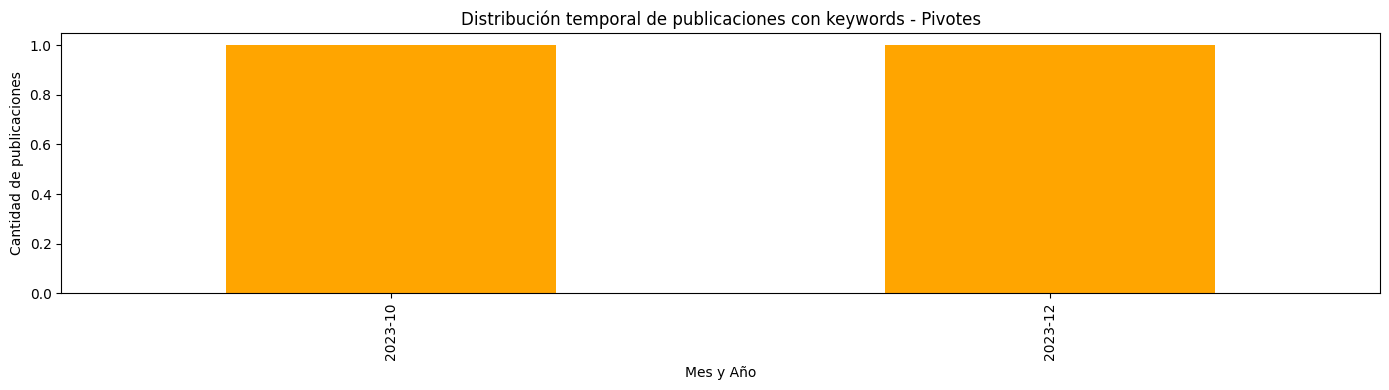

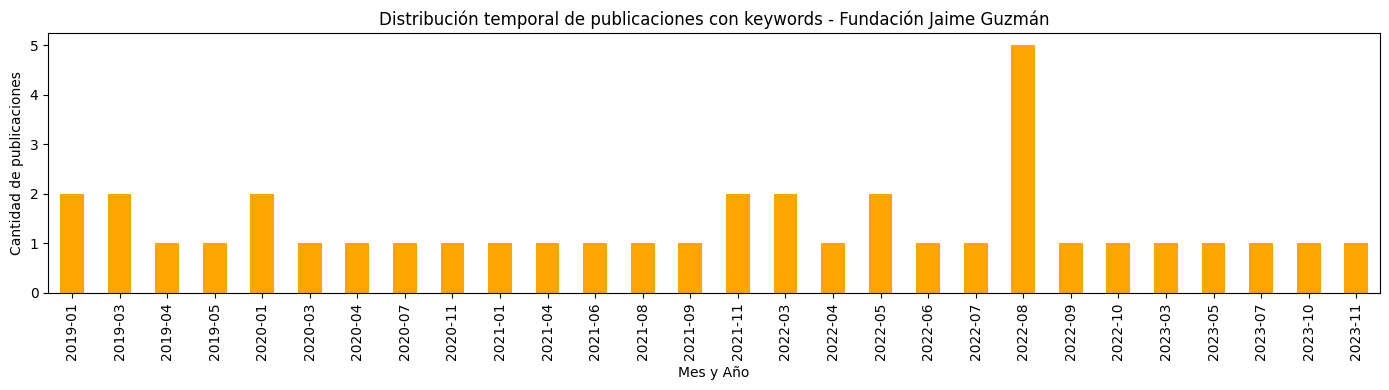

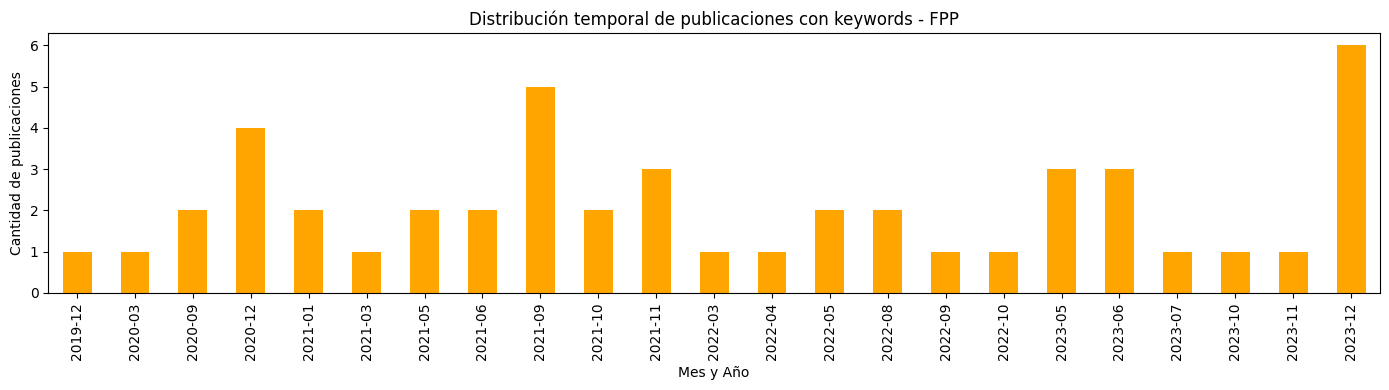

In [26]:
df_focus["fecha_str"] = df_focus["FechaPublicacion"].dt.strftime("%Y-%m")
thinks = df_focus["Think Tank"].unique()

for tt in thinks:
    df_tt = df_focus[df_focus["Think Tank"] == tt]
    timeline = df_tt["fecha_str"].value_counts().sort_index()
    plt.figure(figsize=(14, 4))
    timeline.plot(kind="bar", color="orange")
    plt.title(f"Distribución temporal de publicaciones con keywords - {tt}")
    plt.xlabel("Mes y Año")
    plt.ylabel("Cantidad de publicaciones")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
from textblob import TextBlob

def obtener_sentimiento(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

print("Calculando sentimiento para documentos filtrados...")
df_focus["sentimiento"] = df_focus["TextoLimpio"].apply(obtener_sentimiento)

Calculando sentimiento para documentos filtrados...


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_4892\3801434173.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["sentimiento"] = df_focus["TextoLimpio"].apply(obtener_sentimiento)


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_4892\1199235944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus["FechaDia"] = df_focus["FechaPublicacion"].dt.to_period("M")


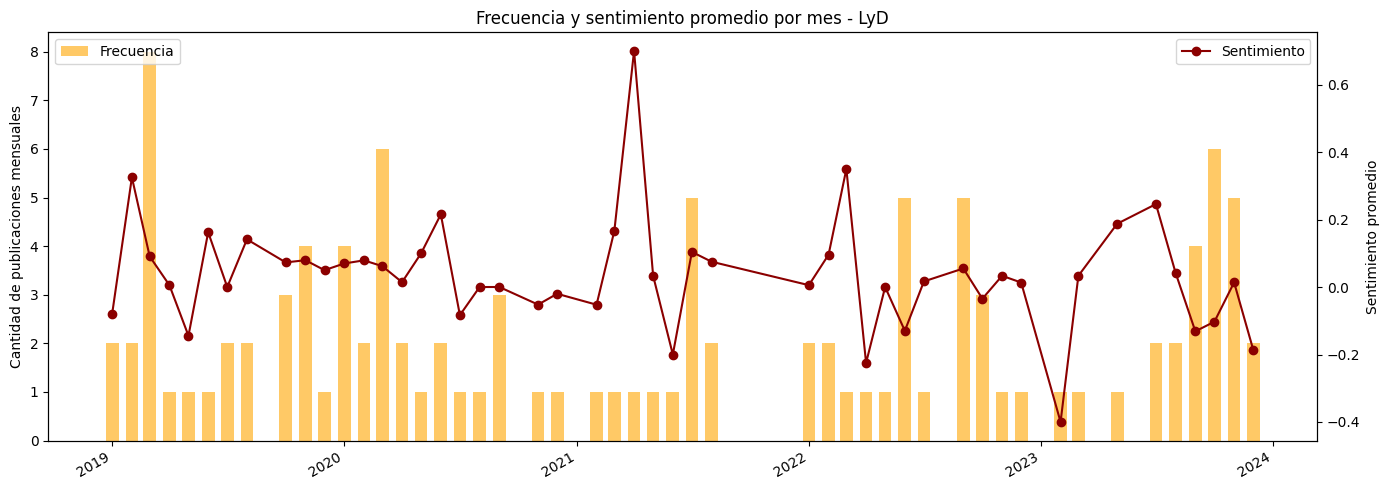

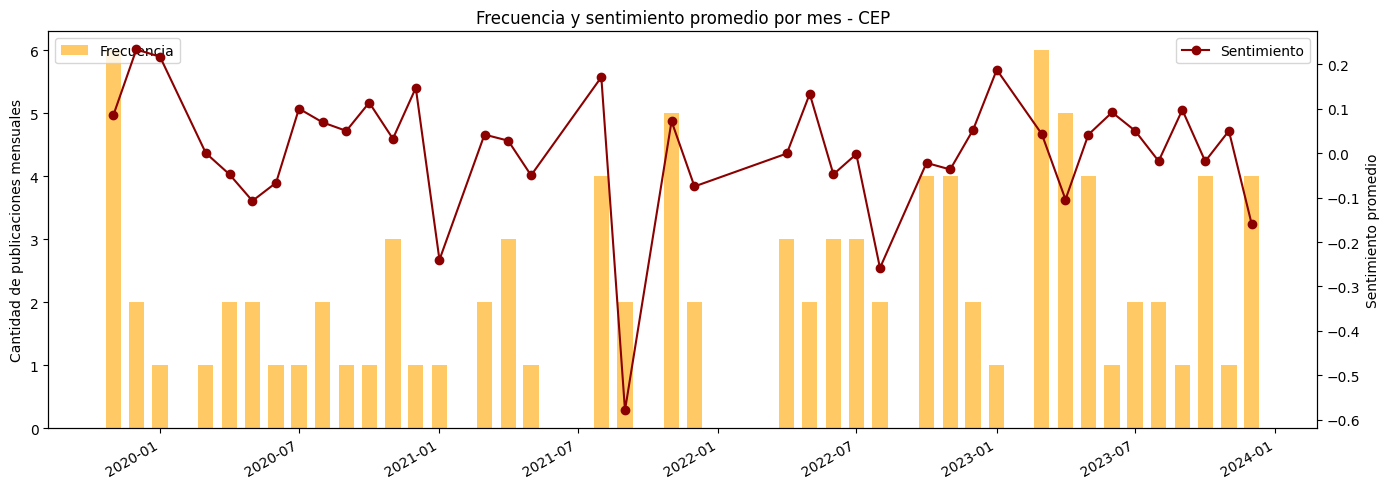

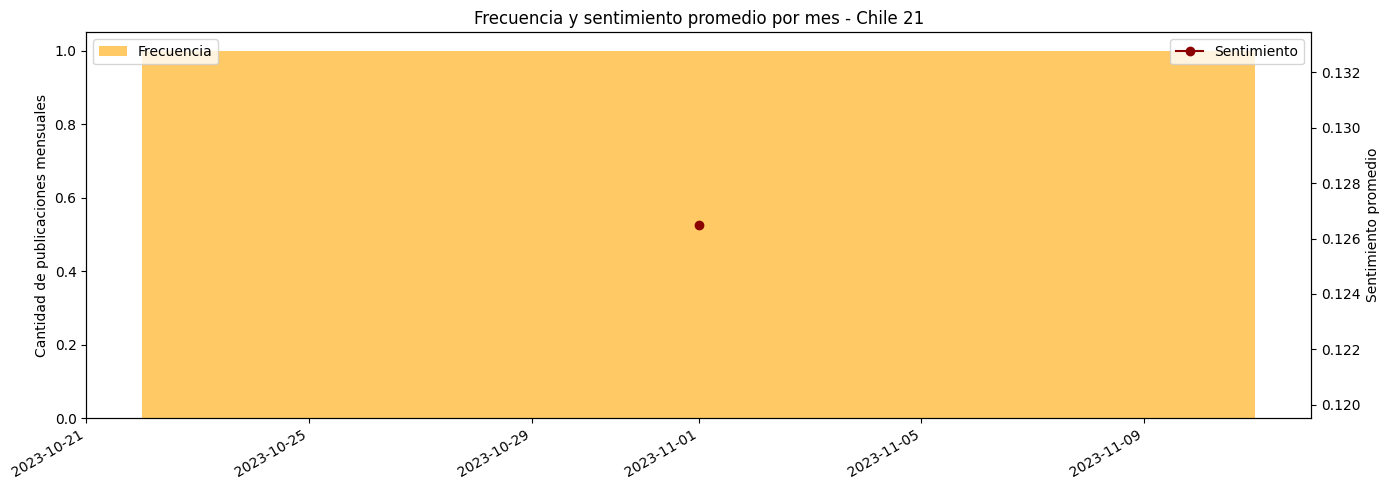

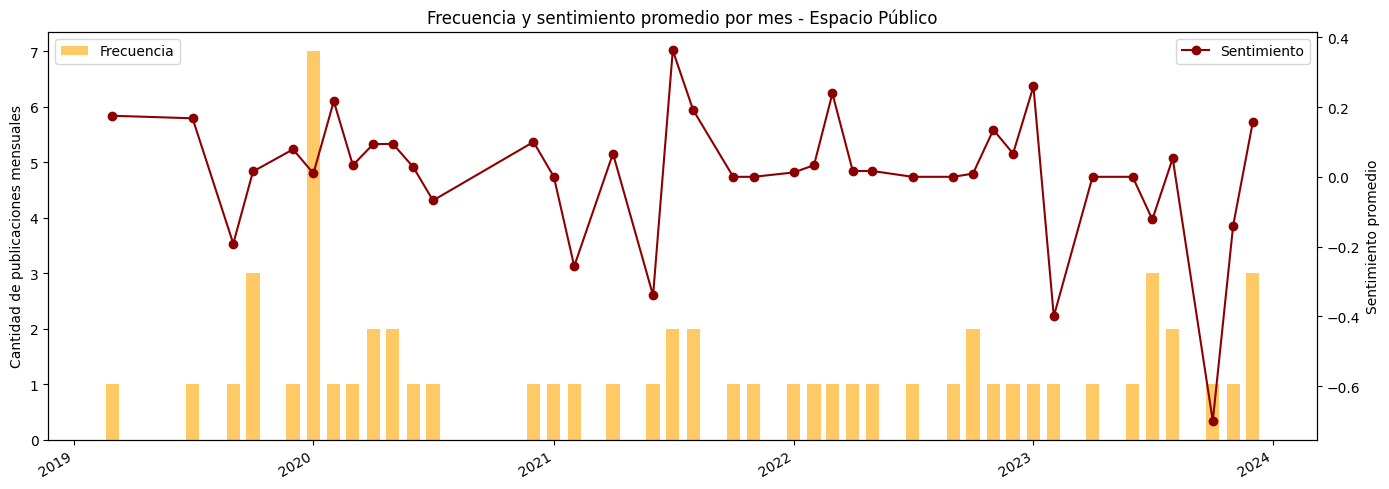

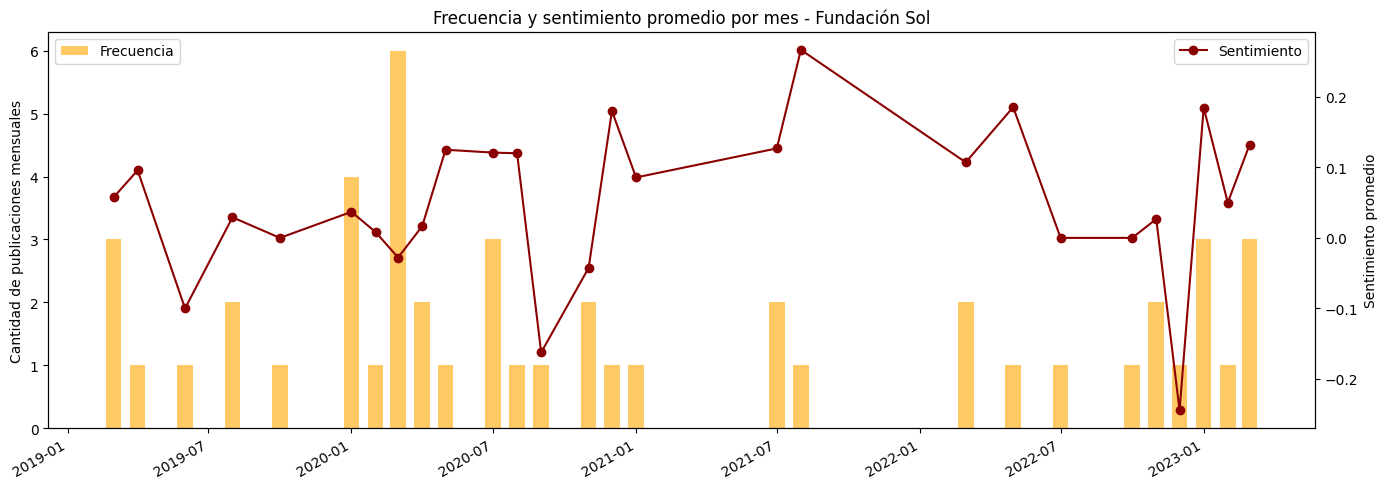

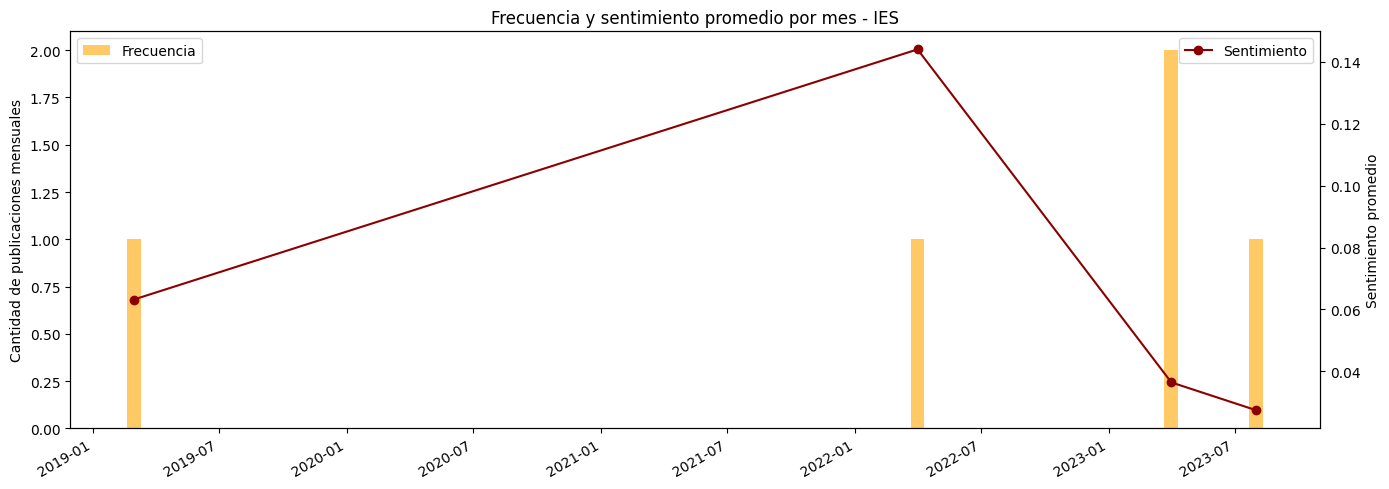

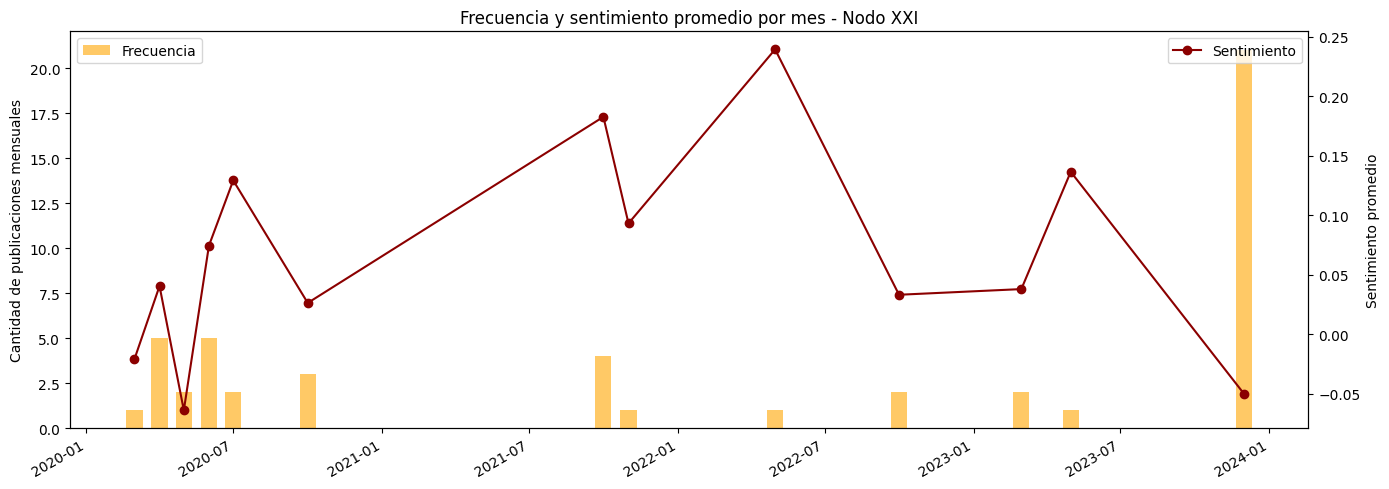

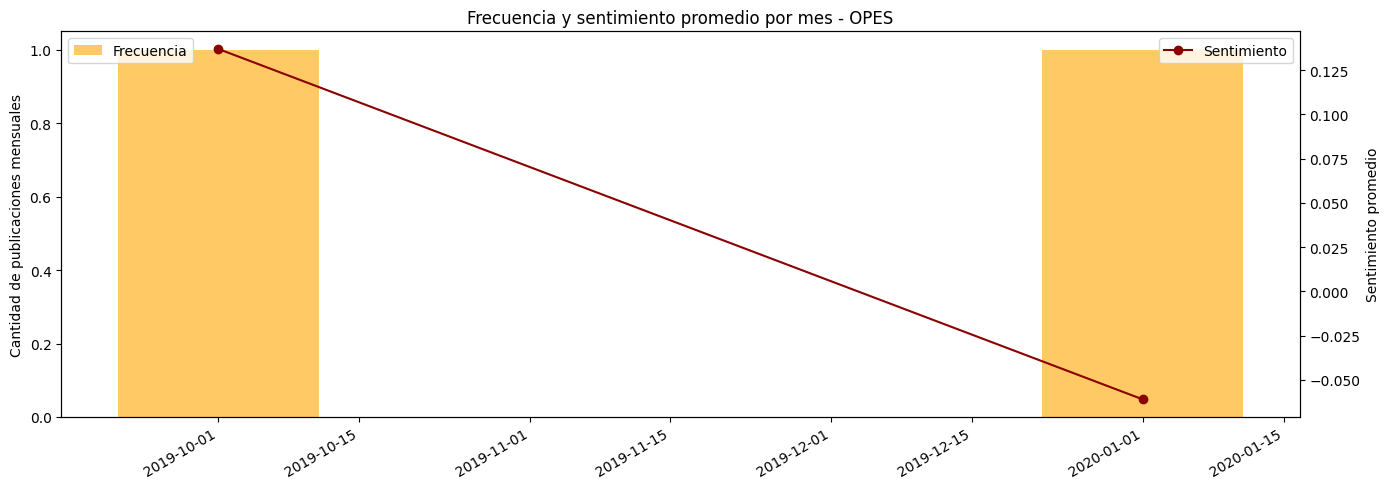

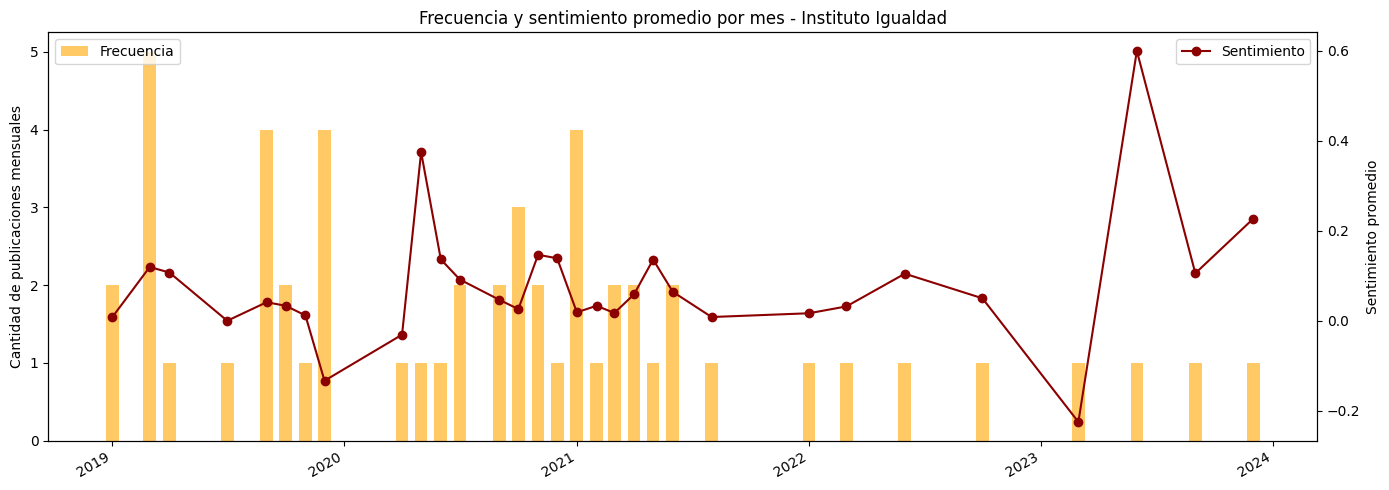

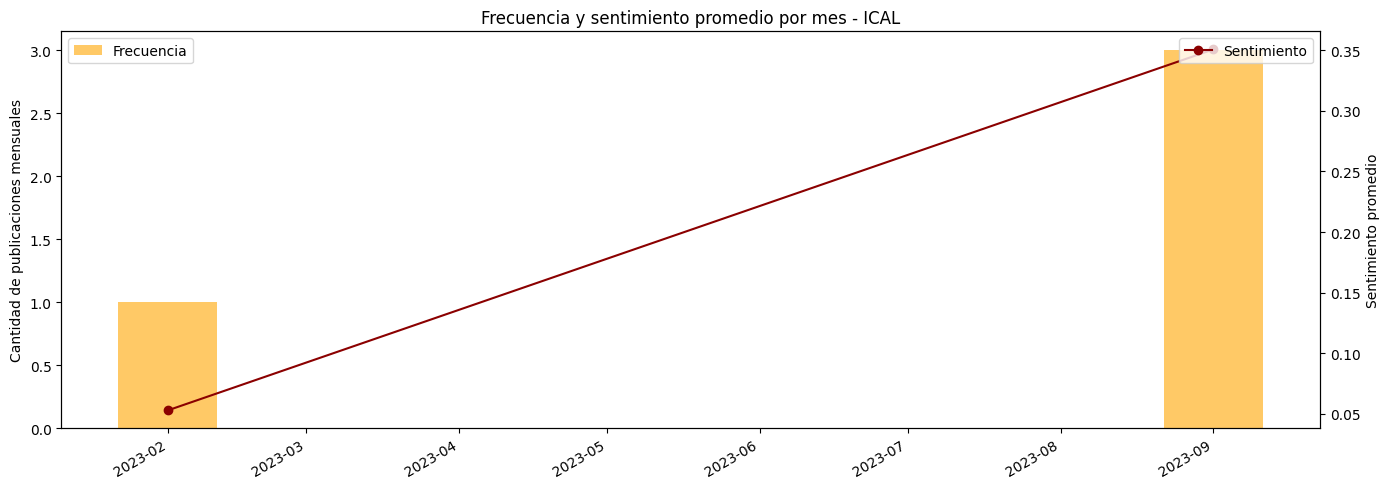

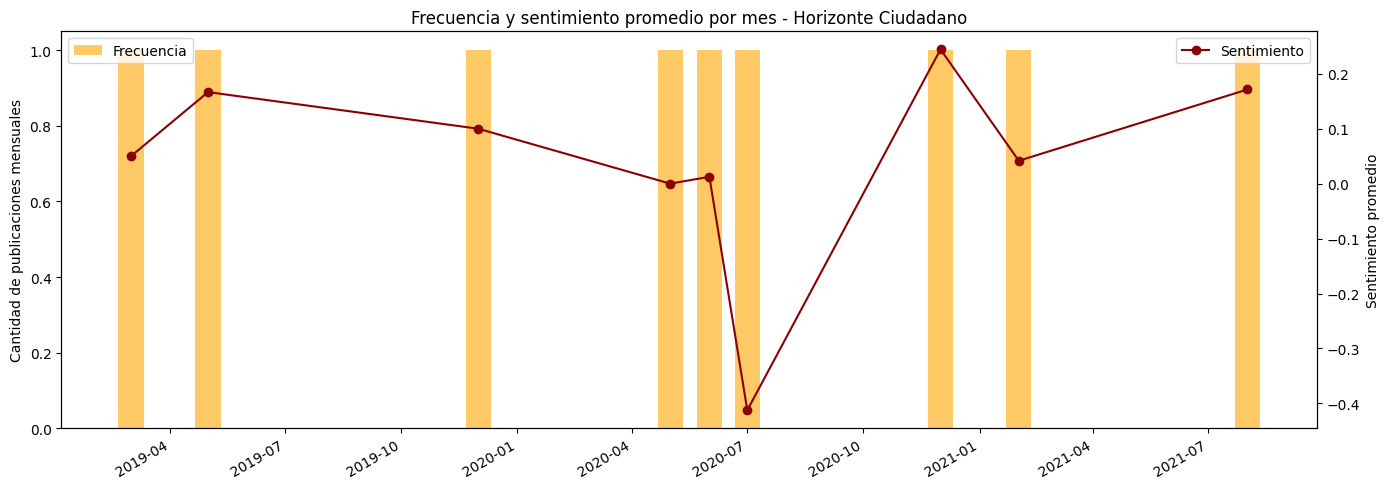

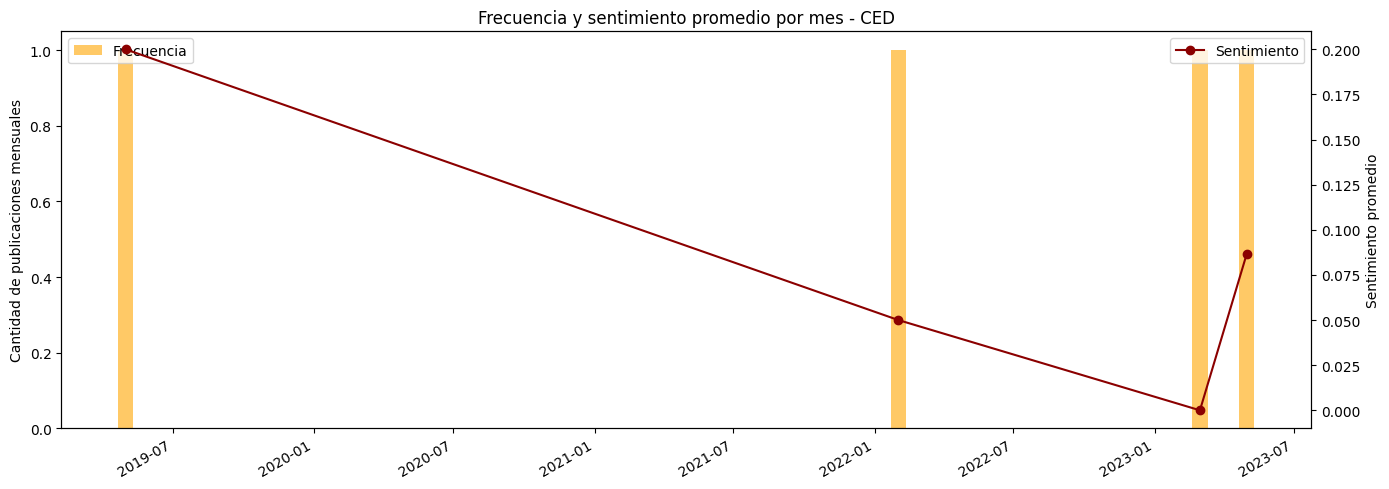

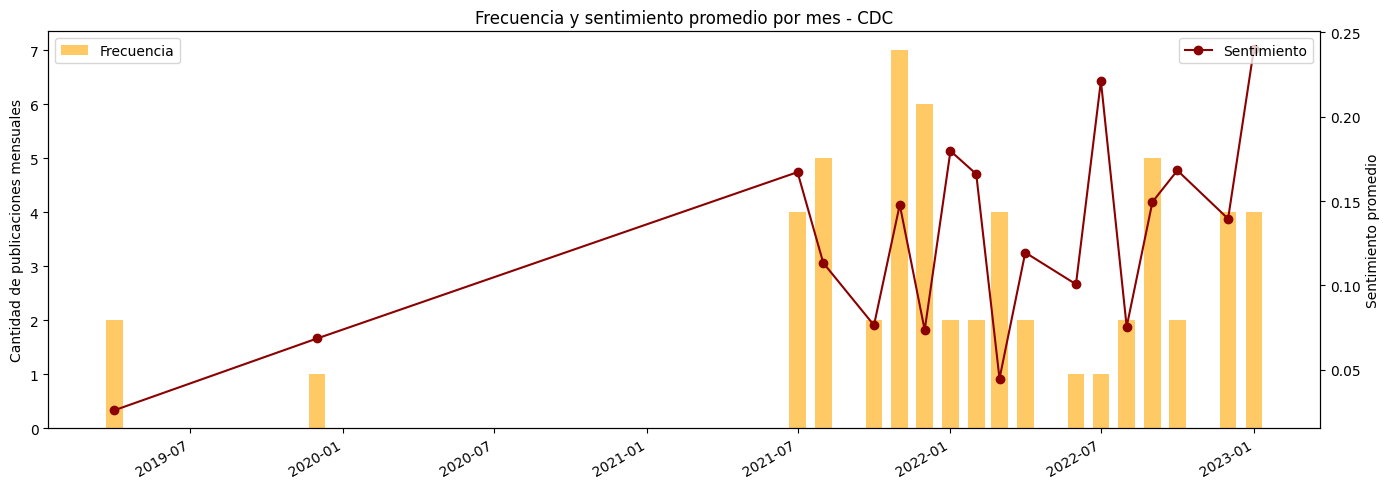

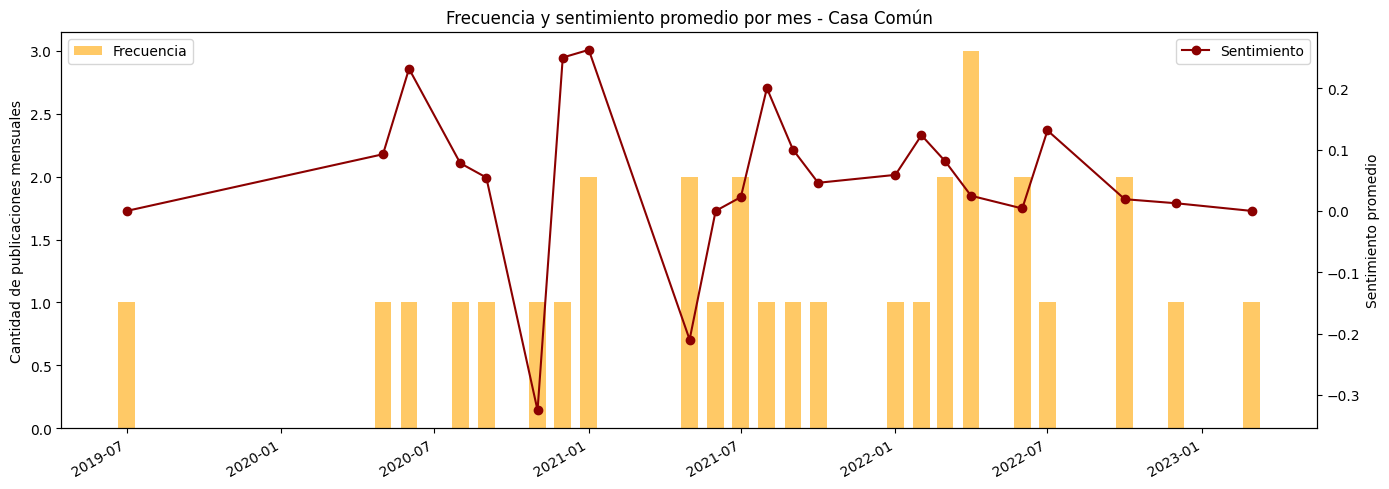

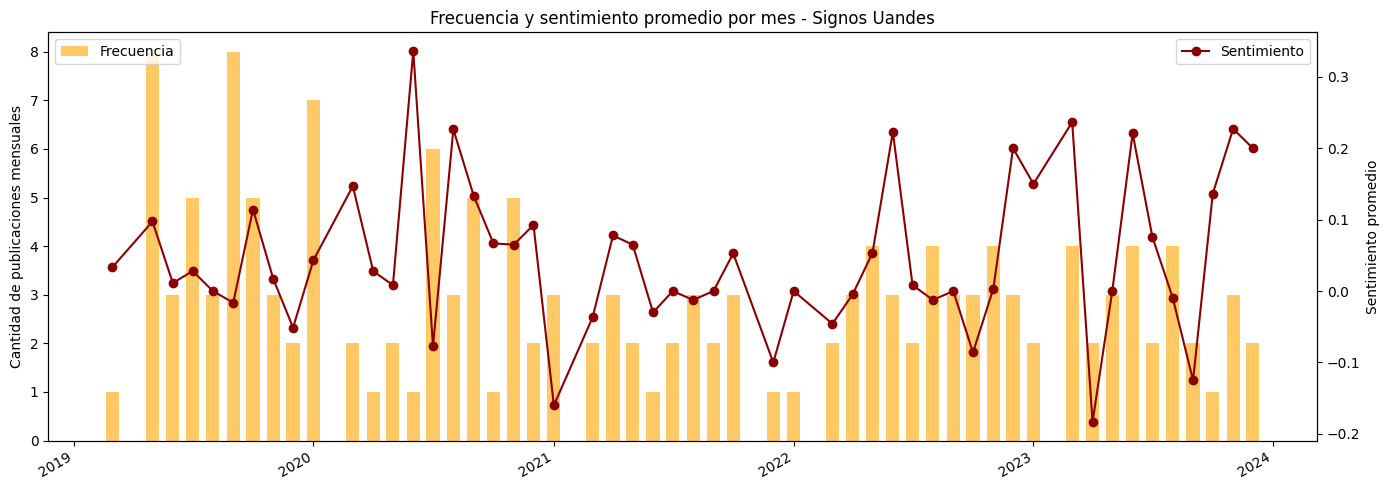

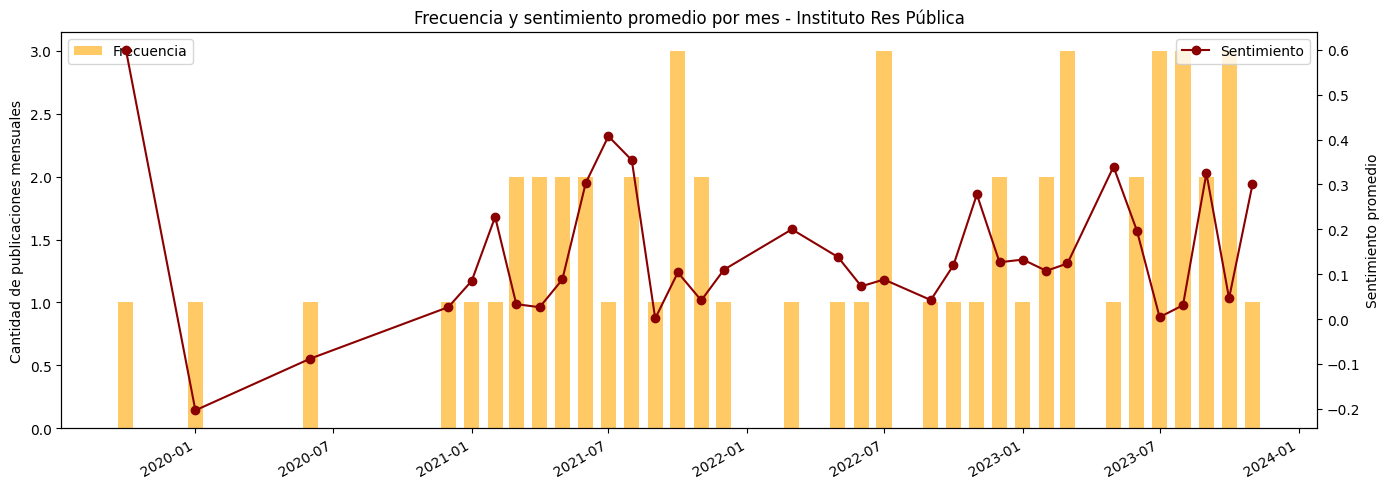

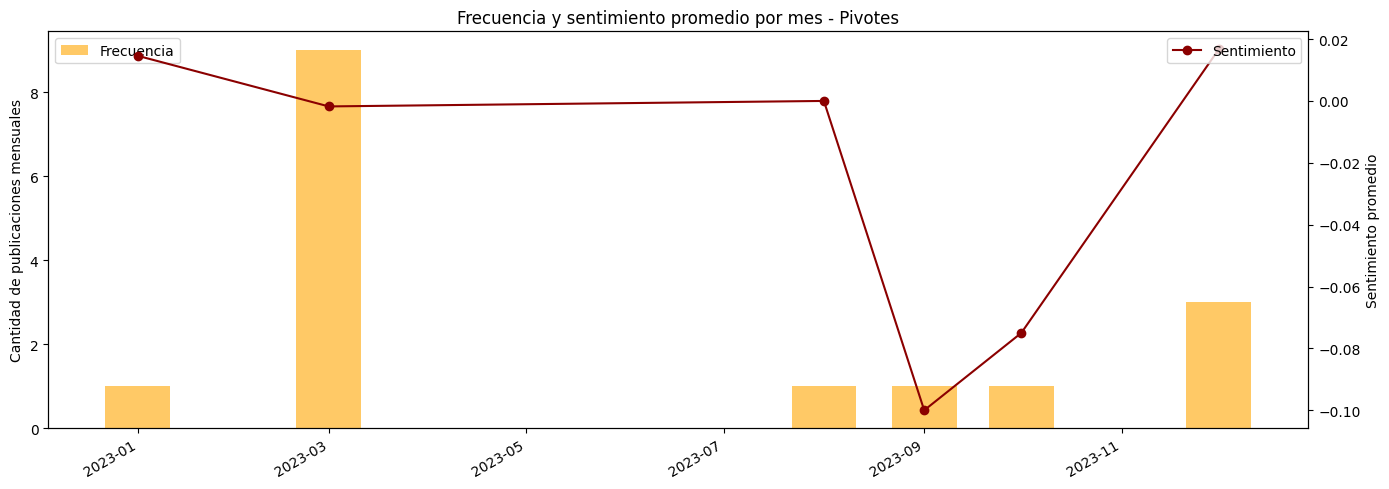

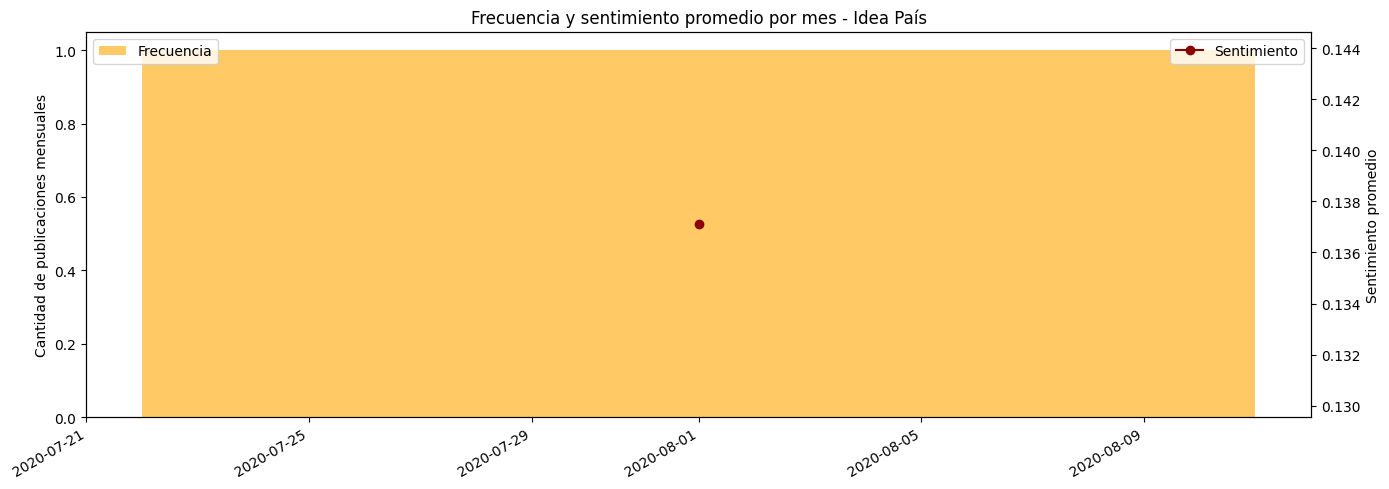

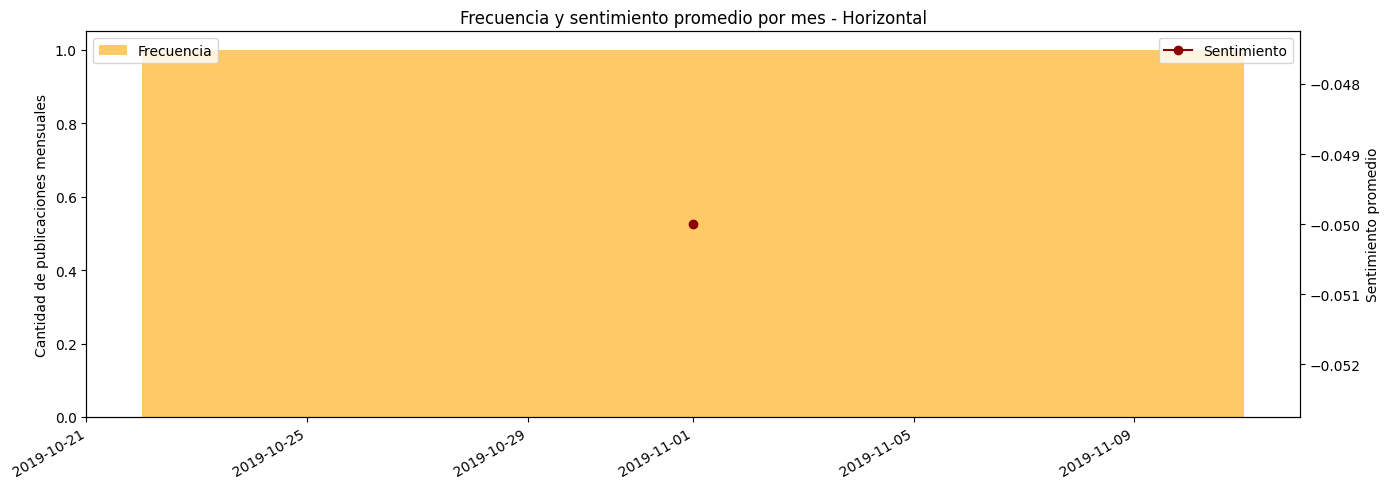

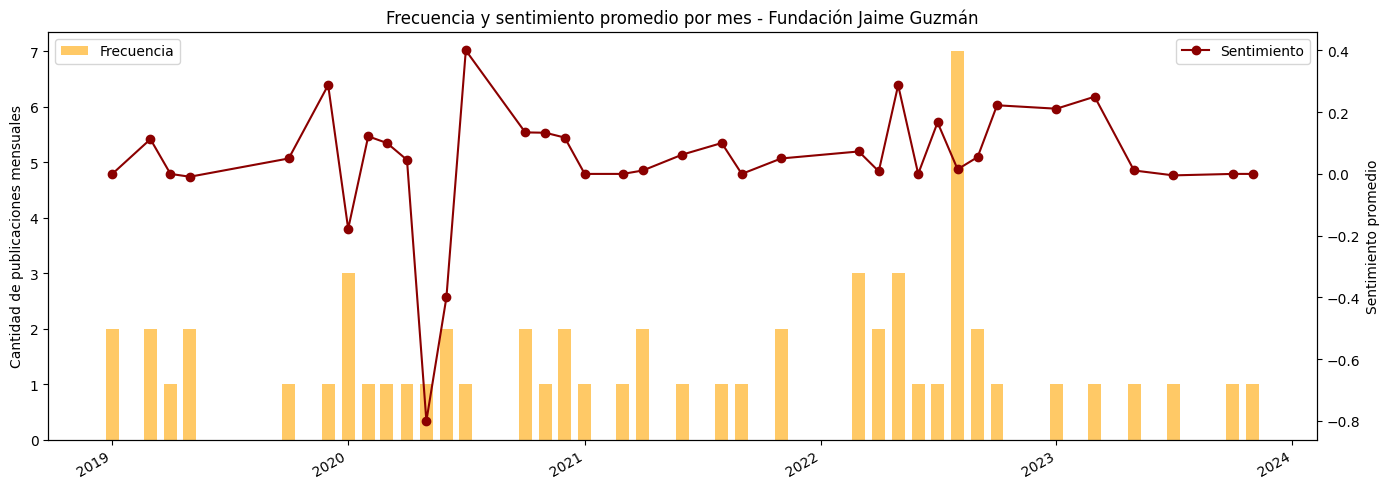

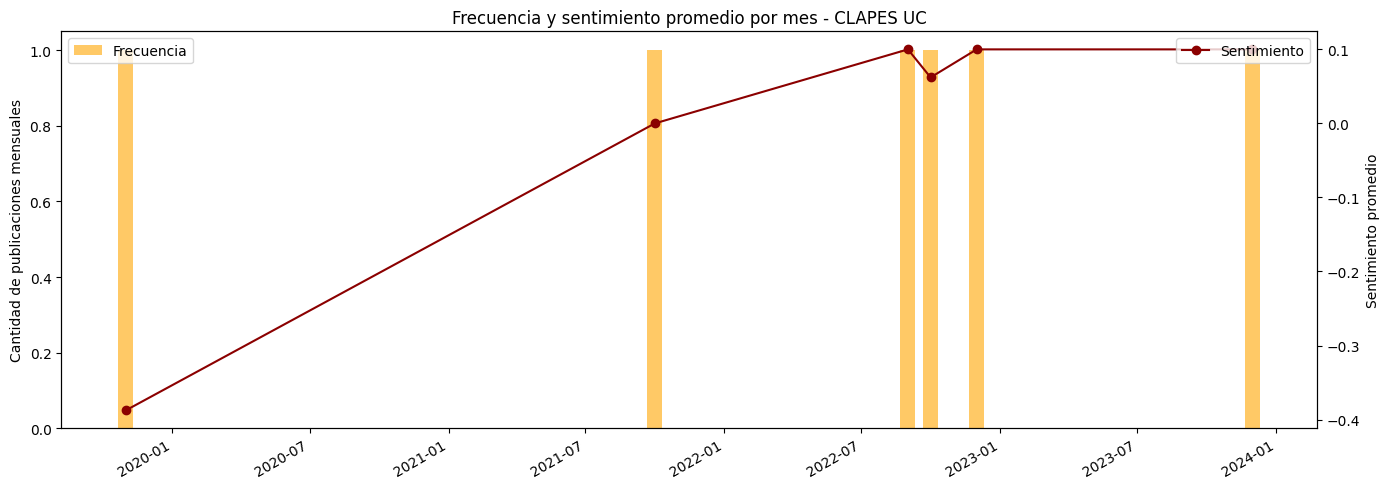

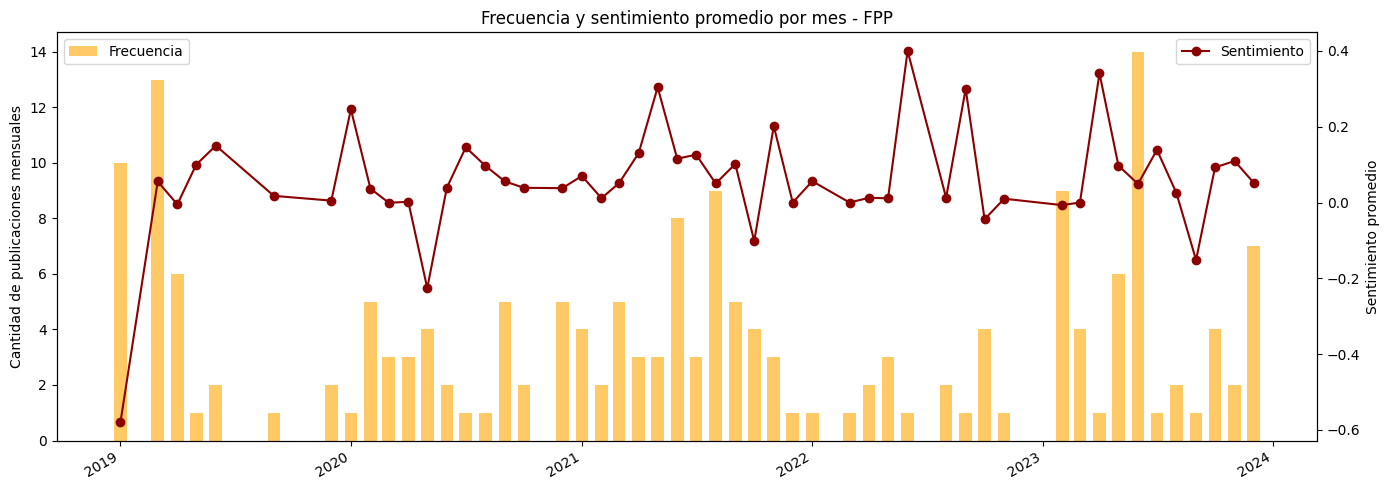

In [ ]:
df_focus["FechaDia"] = df_focus["FechaPublicacion"].dt.to_period("M")
for tt in thinks:
    df_tt = df_focus[df_focus["Think Tank"] == tt].copy()
    resumen = df_tt.groupby("FechaDia").agg({"TextoLimpio": "count", "sentimiento": "mean"}).rename(columns={"TextoLimpio": "Frecuencia"})
    resumen.index = resumen.index.to_timestamp()
    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_title(f"Frecuencia y sentimiento promedio por mes - {tt}")
    ax1.bar(resumen.index, resumen["Frecuencia"], width=20, color="orange", alpha=0.6, label="Frecuencia")
    ax1.set_ylabel("Cantidad de publicaciones mensuales")

    ax2 = ax1.twinx()
    ax2.plot(resumen.index, resumen["sentimiento"], color="darkred", marker="o", label="Sentimiento")
    ax2.set_ylabel("Sentimiento promedio")

    fig.autofmt_xdate()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()